# Prepare data for clustering lab

**NOTE**: make sure, to run this notebook, you have installed [`rtree`](https://pypi.python.org/pypi/Rtree/).

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as geoms

print gpd.__version__

0.2.0.dev-unknown


Paths:

In [2]:
gz_link = '../../../../data/airbnb/listings.csv.gz'
msoas_link = '../../../../data/London Output Area Classification/Shapefiles/london_msoas.shp'

Subset of variables of interest:

In [3]:
x = ['id', 'longitude', 'latitude', 'property_type', 'room_type', 'accommodates', \
     'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', \
     'number_of_reviews', 'reviews_per_month', \
     'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', \
     'review_scores_checkin', 'review_scores_communication', 'review_scores_location', \
     'review_scores_value']

In [4]:
db = pd.read_csv(gz_link)
db = db[x].dropna()
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8433 entries, 0 to 25354
Data columns (total 20 columns):
id                             8433 non-null int64
longitude                      8433 non-null float64
latitude                       8433 non-null float64
property_type                  8433 non-null object
room_type                      8433 non-null object
accommodates                   8433 non-null int64
bathrooms                      8433 non-null float64
bedrooms                       8433 non-null float64
beds                           8433 non-null float64
price                          8433 non-null object
security_deposit               8433 non-null object
number_of_reviews              8433 non-null int64
reviews_per_month              8433 non-null float64
review_scores_rating           8433 non-null float64
review_scores_accuracy         8433 non-null float64
review_scores_cleanliness      8433 non-null float64
review_scores_checkin          8433 non-null float64
r

Convert lat/lon to proper geoms:

In [5]:
geos = gpd.GeoSeries(db[['longitude', 'latitude']]\
            .apply(lambda x: geoms.Point((x.longitude, x.latitude)), axis=1), \
            crs={'init': 'epsg:4326'})
geos = geos.to_crs(epsg=27700)
db['geometry'] = geos
db = gpd.GeoDataFrame.from_records(db)
db.crs = geos.crs

## Clip Inner London

We use the London boroughs geometries ([source](https://github.com/radoi90/housequest-data/blob/master/london_boroughs.geojson)) and the WikiPedia definition of [Inner London](https://en.wikipedia.org/wiki/Inner_London) to extract its shape:

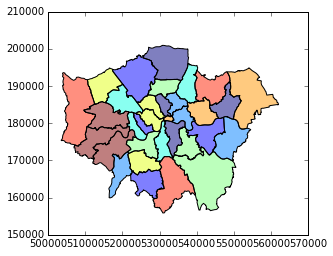

In [6]:
lnd_bor = gpd.read_file('../../../../data/airbnb/london_boroughs.geojson', \
                        driver='GeoJSON').set_index('name')
lnd_bor = lnd_bor.to_crs(epsg=27700)
lnd_bor.plot()

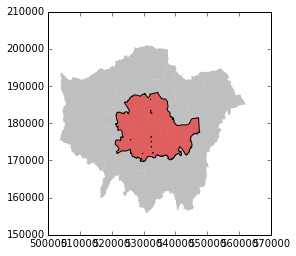

In [7]:
inner_bor_names = ['Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', \
             'Islington', 'Kensington and Chelsea', 'Lambeth', 'Lewisham', \
             'Southwark', 'Tower Hamlets', 'Wandsworth', 'Westminster', \
             'City of London']
inner_bor = lnd_bor.reindex(inner_bor_names)
inner_bor = inner_bor.unary_union

f, ax = plt.subplots(1, figsize=(4, 4))
lnd_bor.plot(ax=ax, color='grey', linewidth=0)
gpd.plotting.plot_multipolygon(ax, inner_bor)

Load up London MSOAs and keep only those whose centroid is inside Inner London:

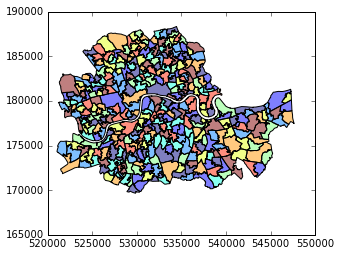

In [8]:
msoas = gpd.read_file(msoas_link)
inner_lnd_flag = msoas.centroid.within(inner_bor)
inner_msoas = msoas.loc[inner_lnd_flag, :].to_crs(epsg=27700)
inner_msoas.plot()

## Inner London AirBnb locations

Join AirBnb locations to MSOAs:

In [9]:
db.crs

{'init': 'epsg:27700', 'no_defs': True}

In [10]:
inner_msoas.crs

{'init': 'epsg:27700', 'no_defs': True}

In [11]:
%%time
# You will need the rtree extension for this
from geopandas.tools import sjoin

abb_msoa = sjoin(db, inner_msoas, how='left')
# Keep complete rows
abb_msoa = abb_msoa.drop('OA11_LSO_6', axis=1)\
                   .dropna()\
                   [x + ['OA11_LSO_2', 'geometry']]\
                   .rename(columns={'OA11_LSO_2': 'MSOA_id'})

CPU times: user 1.3 s, sys: 4 ms, total: 1.31 s
Wall time: 1.31 s


## Aggregate points by MSOA

Get a table for all the Inner London MSOAs with average values of AirBnb attributes:

In [12]:
g = abb_msoa.groupby('MSOA_id')
ilm_abb = g.mean()
ilm_abb['property_count'] = g.size()
# Decided to keep only non-zero polygons
#ilm_abb = ilm_abb.reindex(inner_msoas['OA11_LSO_2'])

In [13]:
ilm_abb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, E02000001 to E02006931
Data columns (total 17 columns):
id                             320 non-null float64
longitude                      320 non-null float64
latitude                       320 non-null float64
accommodates                   320 non-null float64
bathrooms                      320 non-null float64
bedrooms                       320 non-null float64
beds                           320 non-null float64
number_of_reviews              320 non-null float64
reviews_per_month              320 non-null float64
review_scores_rating           320 non-null float64
review_scores_accuracy         320 non-null float64
review_scores_cleanliness      320 non-null float64
review_scores_checkin          320 non-null float64
review_scores_communication    320 non-null float64
review_scores_location         320 non-null float64
review_scores_value            320 non-null float64
property_count                 320 non-null int64
dtyp

## Join back to MSOA polygons

In [14]:
ilm_abb['geometry'] = inner_msoas.set_index('OA11_LSO_2')\
                                 .reindex(ilm_abb.index)\
                                 ['geometry']
ilm_abb = gpd.GeoDataFrame(ilm_abb, crs=inner_msoas.crs)

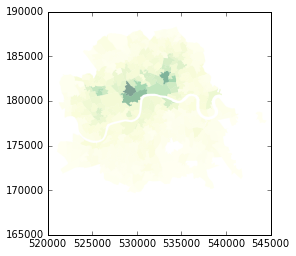

In [15]:
ilm_abb.plot(column='property_count', cmap='YlGn', linewidth=0)

* Clean table before writing out:

In [16]:
ilm_abb['MSOA_id'] = ilm_abb.index
ilm_abb = ilm_abb.drop(['id', 'longitude', 'latitude'], axis=1)

* Write into a `geojson`:

In [17]:
ilm_abb.to_file('../../../../data/airbnb/ilm_abb.geojson', driver='GeoJSON')